In [34]:
import os
import pickle
import random
import time

import PIL
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from tensorflow.keras import Input, Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, ReLU, Reshape, UpSampling2D, Conv2D, Activation, \
    concatenate, Flatten, Lambda, Concatenate
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt


import tensorflow as tf
    
with tf.device('/gpu:0'):
    def load_class_ids(class_info_file_path):
        """
        Load class ids from class_info.pickle file
        """
        with open(class_info_file_path, 'rb') as f:
            class_ids = pickle.load(f, encoding='latin1')
            return class_ids


    def load_embeddings(embeddings_file_path):
        """
        훈련된 텍스트 임베딩을 불러옴
        """
        with open(embeddings_file_path, 'rb') as f:
            embeddings = pickle.load(f, encoding='latin1')
            embeddings = np.array(embeddings)
            print('embeddings: ', embeddings.shape)
        return embeddings

    def load_filenames(filenames_file_path):
        """
        Load filenames.pickle file and return a list of all file names
        """
        with open(filenames_file_path, 'rb') as f:
            filenames = pickle.load(f, encoding='latin1')
        return filenames

    def load_bounding_boxes(dataset_dir):
        """
        이미지와 그에 상응하는 바운딩 박스를 짝지어 딕셔너리로 만들어 출력
        """
        # 바운딩 박스 전체 경로
        bounding_boxes_path = os.path.join(dataset_dir, 'list_bbox_celeba_pure.csv')
        file_paths_path = os.path.join(dataset_dir, 'list_filenames.csv')

        # bounding_boxes.txt 와 images.txt 파일을 읽어옴
        df_bounding_boxes = pd.read_csv(bounding_boxes_path, header=None).astype(int)
        df_file_names = pd.read_csv(file_paths_path, header=None)

        # 전체 이미지 파일 명이 순서대로 적힌 리스트를 만듬
        file_names = df_file_names[0].tolist() 

        # 파일 이름에 대응하는 바운딩 박스가 들어갈 딕셔너리를 만듬 (딕셔너리는 크기를 임의로 증가시킬수 있으므로 초기 사이즈는 아무렇게나)
        filename_boundingbox_dict = {}

        # 이미지 파일과 그에 해당하는 바운딩 박스를 딕셔너리로 만듬 (key = 이미지 파일 이름)
        for i in range(0, len(file_names)):
            # Get the bounding box
            bounding_box = df_bounding_boxes.iloc[i][:].tolist()
            key = file_names[i][:-4] + '.jpg'
            filename_boundingbox_dict[key] = bounding_box

        return filename_boundingbox_dict
    '''
    새 이미지가 크롭핑 되어있지 않기 크롭하기 위한 바운딩 박스 좌표 값이 파일에 주어지며,
    그 파일을 토대로 이미지를 크로핑 한 후,
    크로핑된 모든 이미지를 지정한 이미지 크기 (image_size) 값으로 바꾼다
    '''
    def get_img(img_path, bbox, image_size):
        """
        Load and resize image
        """
        img = Image.open(img_path).convert('RGB')    
        width, height = img.size
        if bbox is not None:
            
            R = int(np.maximum(bbox[2], bbox[3]) * 0.75)
            center_x = int((2 * bbox[0] + bbox[2]) / 2)
            center_y = int((2 * bbox[1] + bbox[3]) / 2)
            y1 = np.maximum(0, center_y - R)
            y2 = np.minimum(height, center_y + R)
            x1 = np.maximum(0, center_x - R)
            x2 = np.minimum(width, center_x + R)
            img = img.crop([x1, y1, x2, y2])
        img = img.resize(image_size, PIL.Image.BILINEAR)
        return img


    def load_dataset(filenames_file_path, cub_dataset_dir, embeddings_file_path, image_size):
        """
        Load dataset
        """
        filenames = load_filenames(filenames_file_path)
        '''
        class_ids = load_class_ids(class_info_file_path)
        '''
        bounding_boxes = load_bounding_boxes(cub_dataset_dir)
        all_embeddings = load_embeddings(embeddings_file_path)

        X, y, embeddings = [], [], []
        
        print("Embeddings shape:", all_embeddings.shape)

        # 각 이미지에 해당하는 바운딩 박스 딕셔너리를 추출하여 get_img 함수로 크로핑되고 같은 크기로 바뀐 이미지를 
        for index, filename in enumerate(filenames):
            bounding_box = bounding_boxes[filename]

            try:
                # Load images
                img_name = '{0}/images/{1}'.format(cub_dataset_dir, filename)
                
                if index == 4:
                    print(filename)
                    print(bounding_box)
                    img = Image.open(img_name).convert('RGB')
                    img.show()
                    
                img = get_img(img_name, bounding_box, image_size)
                '''
                all_embeddings1 = all_embeddings[index, :, :]

                embedding_ix = random.randint(0, all_embeddings1.shape[0] - 1)
                '''
                embedding = all_embeddings[index, :]
                # X = 정제한 이미지 리스트
                X.append(np.array(img))
                '''
                # y = 정제한 이미지 인덱스
                y.append(class_ids[index])
                '''
                # embeddings = 
                embeddings.append(embedding)
            except Exception as e:
                print(e)

        X = np.array(X)
        y = np.array(y)
        embeddings = np.array(embeddings)
        return X, embeddings


    def generate_c(x):
        mean = x[:, :128]
        log_sigma = x[:, 128:]
        stddev = K.exp(log_sigma)
        epsilon = K.random_normal(shape=K.constant((mean.shape[1],), dtype='int32'))
        c = stddev * epsilon + mean
        return c


    def build_ca_model():
        """
        (1024,)의 텍스트 인코더 신경망의 출력을 입력으로 받고 (256,) 의 텐서를 출력
        """
        input_layer = Input(shape=(1024,))
        x = Dense(256)(input_layer)
        x = LeakyReLU(alpha=0.2)(x)
        model = Model(inputs=[input_layer], outputs=[x])
        return model


    def build_embedding_compressor_model():
        """
        입력 속성값 (40,) 을 (128,) 의 벡터로 확장하는 네트워크
        """
        input_layer = Input(shape=(40,))
        x = Dense(128)(input_layer)
        x = ReLU()(x)

        model = Model(inputs=[input_layer], outputs=[x])
        return model


    def build_stage1_generator():
        """
        Stage-I 의 generator 
        *** 이 신경망 안에 CA 신경망과 생성기 신경망이 들어가 있다!!!! ***
        그러므로, 입력으로 텍스트 임베딩 출력 (1024,)과 잡음 변수(100,) 을 받는다
        """
        '''
        input_layer = Input(shape=(1024,))
        x = Dense(256)(input_layer)
        mean_logsigma = LeakyReLU(alpha=0.2)(x)

        c = Lambda(generate_c)(mean_logsigma)

        input_layer2 = Input(shape=(100,))
        gen_input = Concatenate(axis=1)([c, input_layer2])
        '''
        # 텍스트 조건부 변수를 잡음 변수와 접합(concatenation) -> cGAN

        input_layer = Input(shape=(40,))
        x = Dense(128 * 8 * 4 * 4, use_bias=False)(input_layer)
        x = ReLU()(x)

        x = Reshape((4, 4, 128 * 8), input_shape=(128 * 8 * 4 * 4,))(x)

        x = UpSampling2D(size=(2, 2))(x)
        x = Conv2D(512, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

        x = UpSampling2D(size=(2, 2))(x)
        x = Conv2D(256, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

        x = UpSampling2D(size=(2, 2))(x)
        x = Conv2D(128, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

        x = UpSampling2D(size=(2, 2))(x)
        x = Conv2D(64, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

        x = Conv2D(3, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
        x = Activation(activation='tanh')(x)

        stage1_gen = Model(inputs=input_layer, outputs=x)
        '''
        stage - I gen 은 입력된 문장의 임베딩을 바탕으로 (+잡음 변수) 이미지를 생성 함 
        '''
        return stage1_gen


    def build_stage1_discriminator():
        """
        Create a model which takes two inputs
        1. One from above network
        2. One from the embedding layer
        3. Concatenate along the axis dimension and feed it to the last module which produces final logits
        """
        input_layer = Input(shape=(64, 64, 3))

        x = Conv2D(64, (4, 4),
                   padding='same', strides=2,
                   input_shape=(64, 64, 3), use_bias=False)(input_layer)
        x = LeakyReLU(alpha=0.2)(x)

        x = Conv2D(128, (4, 4), padding='same', strides=2, use_bias=False)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)

        x = Conv2D(256, (4, 4), padding='same', strides=2, use_bias=False)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)

        x = Conv2D(512, (4, 4), padding='same', strides=2, use_bias=False)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)

        '''
        실제 이미지에 해당하는 압축된 임베딩을 입력
        '''
        input_layer2 = Input(shape=(4, 4, 128))

        '''
        입력 이미지와 압축 텍스트 임베딩을 합침
        '''
        merged_input = concatenate([x, input_layer2])

        x2 = Conv2D(64 * 8, kernel_size=1,
                    padding="same", strides=1)(merged_input)
        x2 = BatchNormalization()(x2)
        x2 = LeakyReLU(alpha=0.2)(x2)
        x2 = Flatten()(x2)
        x2 = Dense(1)(x2)
        x2 = Activation('sigmoid')(x2)

        stage1_dis = Model(inputs=[input_layer, input_layer2], outputs=x2)
        '''
        출력은 입력 이미지가 진짜인지 가짜인지에 관한 확률(sigmoid)을 출력
        '''
        return stage1_dis


    def build_adversarial_model(gen_model, dis_model):
        input_layer = Input(shape=(40,))
        input_layer3 = Input(shape=(4, 4, 128))

        x = gen_model(input_layer)

        dis_model.trainable = False
        valid = dis_model([x, input_layer3])

        model = Model(inputs=[input_layer, input_layer3], outputs=valid)
        return model


    def KL_loss(y_true, y_pred):
        mean = y_pred[:, :128]
        logsigma = y_pred[:, :128]
        loss = -logsigma + .5 * (-1 + K.exp(2. * logsigma) + K.square(mean))
        loss = K.mean(loss)
        return loss


    def custom_generator_loss(y_true, y_pred):
        # Calculate binary cross entropy loss
        return K.binary_crossentropy(y_true, y_pred)


    def save_rgb_img(img, path):
        """
        Save an rgb image
        """
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title("Image")

        plt.savefig(path)
        plt.close()


    def write_log(callback, name, loss, batch_no):
        """
        Write training summary to TensorBoard
        """
        with callback.as_default():
              tf.summary.scalar(name, loss, batch_no)
              callback.flush()
 







    '''
    Stage - I stackGAN 훈련
    '''
    if __name__ == '__main__':
        '''
        하이퍼파라미터(불변 파라미터) 지정
        '''
        data_dir = "/home/csle/Desktop/CelebA_dataset_reduce"
        train_dir = data_dir + "/train"
        test_dir = data_dir + "/test"
        image_size = 64
        batch_size = 100
        z_dim = 100
        stage1_generator_lr = 0.00008
        stage1_discriminator_lr = 0.00008
        stage1_lr_decay_step = 600
        epochs = 200
        condition_dim = 128

        embeddings_file_path_train = train_dir + "/attr_(embeddings).pickle"
        embeddings_file_path_test = test_dir + "/attr_(embeddings).pickle"

        filenames_file_path_train = train_dir + "/filenames.pickle"
        filenames_file_path_test = test_dir + "/filenames.pickle"

        '''
        class_info_file_path_train = train_dir + "/class_info.pickle"
        class_info_file_path_test = test_dir + "/class_info.pickle"
        '''

        cub_dataset_dir = data_dir + "/img_align_celeba"

        '''
        optimizer 정의
        '''
        dis_optimizer = Adam(lr=stage1_discriminator_lr, beta_1=0.5, beta_2=0.999)
        gen_optimizer = Adam(lr=stage1_generator_lr, beta_1=0.5, beta_2=0.999)

        """"
        dataset 로드하기
        """
        X_train, embeddings_train = load_dataset(filenames_file_path=filenames_file_path_train,
                                                          cub_dataset_dir=cub_dataset_dir,
                                                          embeddings_file_path=embeddings_file_path_train,
                                                          image_size=(64, 64))

        X_test, embeddings_test = load_dataset(filenames_file_path=filenames_file_path_test,
                                                       cub_dataset_dir=cub_dataset_dir,
                                                       embeddings_file_path=embeddings_file_path_test,
                                                       image_size=(64, 64))


embeddings:  (16000, 40)
Embeddings shape: (16000, 40)
016953.jpg
[144, 135, 283, 345]
embeddings:  (4000, 40)
Embeddings shape: (4000, 40)
001545.jpg
[92, 157, 515, 713]


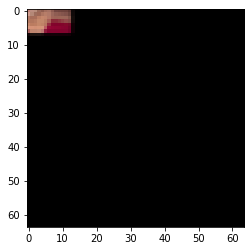

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.imshow(X_train[4])
plt.imshow(X_test[4])

In [1]:
import os
import pickle
import random
import time

import PIL
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from tensorflow.keras import Input, Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, ReLU, Reshape, UpSampling2D, Conv2D, Activation, \
    concatenate, Flatten, Lambda, Concatenate
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt


import tensorflow as tf
    
with tf.device('/gpu:0'):
    def load_class_ids(class_info_file_path):
        """
        Load class ids from class_info.pickle file
        """
        with open(class_info_file_path, 'rb') as f:
            class_ids = pickle.load(f, encoding='latin1')
            return class_ids


    def load_embeddings(embeddings_file_path):
        """
        훈련된 텍스트 임베딩을 불러옴
        """
        with open(embeddings_file_path, 'rb') as f:
            embeddings = pickle.load(f, encoding='latin1')
            embeddings = np.array(embeddings)
            print('embeddings: ', embeddings.shape)
        return embeddings

    def load_filenames(filenames_file_path):
        """
        Load filenames.pickle file and return a list of all file names
        """
        with open(filenames_file_path, 'rb') as f:
            filenames = pickle.load(f, encoding='latin1')
        return filenames

    def load_bounding_boxes(dataset_dir):
        """
        이미지와 그에 상응하는 바운딩 박스를 짝지어 딕셔너리로 만들어 출력
        """
        # 바운딩 박스 전체 경로
        bounding_boxes_path = os.path.join(dataset_dir, 'list_bbox_celeba_pure.csv')
        file_paths_path = os.path.join(dataset_dir, 'list_filenames.csv')

        # bounding_boxes.txt 와 images.txt 파일을 읽어옴
        df_bounding_boxes = pd.read_csv(bounding_boxes_path, header=None).astype(int)
        df_file_names = pd.read_csv(file_paths_path, header=None)

        # 전체 이미지 파일 명이 순서대로 적힌 리스트를 만듬
        file_names = df_file_names[0].tolist() 

        # 파일 이름에 대응하는 바운딩 박스가 들어갈 딕셔너리를 만듬 (딕셔너리는 크기를 임의로 증가시킬수 있으므로 초기 사이즈는 아무렇게나)
        filename_boundingbox_dict = {}

        # 이미지 파일과 그에 해당하는 바운딩 박스를 딕셔너리로 만듬 (key = 이미지 파일 이름)
        for i in range(0, len(file_names)):
            # Get the bounding box
            bounding_box = df_bounding_boxes.iloc[i][:].tolist()
            key = file_names[i][:-4] + '.jpg'
            filename_boundingbox_dict[key] = bounding_box

        return filename_boundingbox_dict
    '''
    새 이미지가 크롭핑 되어있지 않기 크롭하기 위한 바운딩 박스 좌표 값이 파일에 주어지며,
    그 파일을 토대로 이미지를 크로핑 한 후,
    크로핑된 모든 이미지를 지정한 이미지 크기 (image_size) 값으로 바꾼다
    '''
    def get_img(img_path, bbox, image_size):
        """
        Load and resize image
        """
        img = Image.open(img_path).convert('RGB')
        width, height = img.size
        if bbox is not None:
            pass
        '''
            R = int(np.maximum(bbox[2], bbox[3]) * 0.75)
            center_x = int((2 * bbox[0] + bbox[2]) / 2)
            center_y = int((2 * bbox[1] + bbox[3]) / 2)
            y1 = np.maximum(0, center_y - R)
            y2 = np.minimum(height, center_y + R)
            x1 = np.maximum(0, center_x - R)
            x2 = np.minimum(width, center_x + R)
            img = img.crop([x1, y1, x2, y2])
        '''
        img = img.resize(image_size, PIL.Image.BILINEAR)
        return img


    def load_dataset(filenames_file_path, cub_dataset_dir, embeddings_file_path, image_size):
        """
        Load dataset
        """
        filenames = load_filenames(filenames_file_path)
        '''
        class_ids = load_class_ids(class_info_file_path)
        '''
        bounding_boxes = load_bounding_boxes(cub_dataset_dir)
        all_embeddings = load_embeddings(embeddings_file_path)

        X, y, embeddings = [], [], []

        print("Embeddings shape:", all_embeddings.shape)

        # 각 이미지에 해당하는 바운딩 박스 딕셔너리를 추출하여 get_img 함수로 크로핑되고 같은 크기로 바뀐 이미지를 
        for index, filename in enumerate(filenames):
            bounding_box = bounding_boxes[filename]

            try:
                # Load images
                img_name = '{0}/images/{1}'.format(cub_dataset_dir, filename)
                img = get_img(img_name, bounding_box, image_size)
                '''
                all_embeddings1 = all_embeddings[index, :, :]

                embedding_ix = random.randint(0, all_embeddings1.shape[0] - 1)
                '''
                embedding = all_embeddings[index, :]
                # X = 정제한 이미지 리스트
                X.append(np.array(img))
                '''
                # y = 정제한 이미지 인덱스
                y.append(class_ids[index])
                '''
                # embeddings = 
                embeddings.append(embedding)
            except Exception as e:
                print(e)

        X = np.array(X)
        y = np.array(y)
        embeddings = np.array(embeddings)
        return X, embeddings


    def generate_c(x):
        mean = x[:, :128]
        log_sigma = x[:, 128:]
        stddev = K.exp(log_sigma)
        epsilon = K.random_normal(shape=K.constant((mean.shape[1],), dtype='int32'))
        c = stddev * epsilon + mean
        return c


    def build_ca_model():
        """
        (1024,)의 텍스트 인코더 신경망의 출력을 입력으로 받고 (256,) 의 텐서를 출력
        """
        input_layer = Input(shape=(1024,))
        x = Dense(256)(input_layer)
        x = LeakyReLU(alpha=0.2)(x)
        model = Model(inputs=[input_layer], outputs=[x])
        return model


    def build_embedding_compressor_model():
        """
        입력 속성값 (40,) 을 (128,) 의 벡터로 확장하는 네트워크
        """
        input_layer = Input(shape=(40,))
        x = Dense(128)(input_layer)
        x = ReLU()(x)

        model = Model(inputs=[input_layer], outputs=[x])
        return model


    def build_stage1_generator():
        """
        Stage-I 의 generator 
        *** 이 신경망 안에 CA 신경망과 생성기 신경망이 들어가 있다!!!! ***
        그러므로, 입력으로 텍스트 임베딩 출력 (1024,)과 잡음 변수(100,) 을 받는다
        """
        '''
        input_layer = Input(shape=(1024,))
        x = Dense(256)(input_layer)
        mean_logsigma = LeakyReLU(alpha=0.2)(x)

        c = Lambda(generate_c)(mean_logsigma)

        input_layer2 = Input(shape=(100,))
        gen_input = Concatenate(axis=1)([c, input_layer2])
        '''
        # 텍스트 조건부 변수를 잡음 변수와 접합(concatenation) -> cGAN

        input_layer = Input(shape=(40,))
        x = Dense(128 * 8 * 4 * 4, use_bias=False)(input_layer)
        x = ReLU()(x)

        x = Reshape((4, 4, 128 * 8), input_shape=(128 * 8 * 4 * 4,))(x)

        x = UpSampling2D(size=(2, 2))(x)
        x = Conv2D(512, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

        x = UpSampling2D(size=(2, 2))(x)
        x = Conv2D(256, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

        x = UpSampling2D(size=(2, 2))(x)
        x = Conv2D(128, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

        x = UpSampling2D(size=(2, 2))(x)
        x = Conv2D(64, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

        x = Conv2D(3, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
        x = Activation(activation='tanh')(x)

        stage1_gen = Model(inputs=input_layer, outputs=x)
        '''
        stage - I gen 은 입력된 문장의 임베딩을 바탕으로 (+잡음 변수) 이미지를 생성 함 
        '''
        return stage1_gen


    def build_stage1_discriminator():
        """
        Create a model which takes two inputs
        1. One from above network
        2. One from the embedding layer
        3. Concatenate along the axis dimension and feed it to the last module which produces final logits
        """
        input_layer = Input(shape=(64, 64, 3))

        x = Conv2D(64, (4, 4),
                   padding='same', strides=2,
                   input_shape=(64, 64, 3), use_bias=False)(input_layer)
        x = LeakyReLU(alpha=0.2)(x)

        x = Conv2D(128, (4, 4), padding='same', strides=2, use_bias=False)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)

        x = Conv2D(256, (4, 4), padding='same', strides=2, use_bias=False)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)

        x = Conv2D(512, (4, 4), padding='same', strides=2, use_bias=False)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)

        '''
        실제 이미지에 해당하는 압축된 임베딩을 입력
        '''
        input_layer2 = Input(shape=(4, 4, 128))

        '''
        입력 이미지와 압축 텍스트 임베딩을 합침
        '''
        merged_input = concatenate([x, input_layer2])

        x2 = Conv2D(64 * 8, kernel_size=1,
                    padding="same", strides=1)(merged_input)
        x2 = BatchNormalization()(x2)
        x2 = LeakyReLU(alpha=0.2)(x2)
        x2 = Flatten()(x2)
        x2 = Dense(1)(x2)
        x2 = Activation('sigmoid')(x2)

        stage1_dis = Model(inputs=[input_layer, input_layer2], outputs=x2)
        '''
        출력은 입력 이미지가 진짜인지 가짜인지에 관한 확률(sigmoid)을 출력
        '''
        return stage1_dis


    def build_adversarial_model(gen_model, dis_model):
        input_layer = Input(shape=(40,))
        input_layer3 = Input(shape=(4, 4, 128))

        x = gen_model(input_layer)

        dis_model.trainable = False
        valid = dis_model([x, input_layer3])

        model = Model(inputs=[input_layer, input_layer3], outputs=valid)
        return model


    def KL_loss(y_true, y_pred):
        mean = y_pred[:, :128]
        logsigma = y_pred[:, :128]
        loss = -logsigma + .5 * (-1 + K.exp(2. * logsigma) + K.square(mean))
        loss = K.mean(loss)
        return loss


    def custom_generator_loss(y_true, y_pred):
        # Calculate binary cross entropy loss
        return K.binary_crossentropy(y_true, y_pred)


    def save_rgb_img(img, path):
        """
        Save an rgb image
        """
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title("Image")

        plt.savefig(path)
        plt.close()


    def write_log(callback, name, loss, batch_no):
        """
        Write training summary to TensorBoard
        """
        with callback.as_default():
              tf.summary.scalar(name, loss, batch_no)
              callback.flush()
 







    '''
    Stage - I stackGAN 훈련
    '''
    if __name__ == '__main__':
        '''
        하이퍼파라미터(불변 파라미터) 지정
        '''
        data_dir = "/home/csle/Desktop/CelebA_dataset_reduce"
        train_dir = data_dir + "/train"
        test_dir = data_dir + "/test"
        image_size = 64
        batch_size = 100
        z_dim = 100
        stage1_generator_lr = 0.0002
        stage1_discriminator_lr = 0.0002
        stage1_lr_decay_step = 600
        epochs = 200
        condition_dim = 128

        embeddings_file_path_train = train_dir + "/attr_(embeddings).pickle"
        embeddings_file_path_test = test_dir + "/attr_(embeddings).pickle"

        filenames_file_path_train = train_dir + "/filenames.pickle"
        filenames_file_path_test = test_dir + "/filenames.pickle"

        '''
        class_info_file_path_train = train_dir + "/class_info.pickle"
        class_info_file_path_test = test_dir + "/class_info.pickle"
        '''

        cub_dataset_dir = data_dir + "/img_align_celeba"

        '''
        optimizer 정의
        '''
        dis_optimizer = Adam(lr=stage1_discriminator_lr, beta_1=0.5, beta_2=0.999)
        gen_optimizer = Adam(lr=stage1_generator_lr, beta_1=0.5, beta_2=0.999)

        """"
        dataset 로드하기
        """
        X_train, embeddings_train = load_dataset(filenames_file_path=filenames_file_path_train,
                                                          cub_dataset_dir=cub_dataset_dir,
                                                          embeddings_file_path=embeddings_file_path_train,
                                                          image_size=(64, 64))

        X_test, embeddings_test = load_dataset(filenames_file_path=filenames_file_path_test,
                                                       cub_dataset_dir=cub_dataset_dir,
                                                       embeddings_file_path=embeddings_file_path_test,
                                                       image_size=(64, 64))


embeddings:  (16000, 40)
Embeddings shape: (16000, 40)
embeddings:  (4000, 40)
Embeddings shape: (4000, 40)


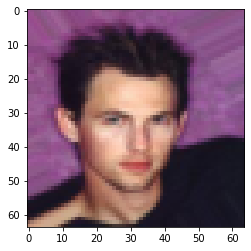

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.imshow(X_train[13])
# plt.imshow(X_test[4])

In [1]:
import tensorflow as tf

tf.test.gpu_device_name()



'/device:GPU:0'